In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from yaml import Loader

plt.rc('font',family='Times New Roman')
# del matplotlib.font_manager.weight_dict['roman']
# matplotlib.font_manager.rebuild()

In [2]:
def read_yaml(filename):
    with open(filename,'r') as f:
        data=yaml.safe_load(f)
    return data

data=read_yaml('band-lmp.yaml')
        

In [3]:
type(data)

dict

In [25]:
data.keys()

dict_keys(['nqpoint', 'npath', 'segment_nqpoint', 'labels', 'reciprocal_lattice', 'natom', 'lattice', 'points', 'phonon'])

In [30]:
# 获取q点数量和能带数量
nqpoints = data['nqpoint']  # q点数量
npath = data['npath']  # 路径数量
segment_nqpoint = data['segment_nqpoint']  # 每个路径的q点数量
labels = data['labels']  # 路径标签
reciprocal_lattice = data['reciprocal_lattice']  # 倒格矢
natom = data['natom']  # 原子数量
lattice = data['lattice']  # 晶格矢量
points = data['points']  # q点坐标
phonon = data['phonon']  # 声子频率
frequency_conversion = data.get(
    'frequency_unit_conversion_factor', 1.0)  # 频率单位转换因子

In [38]:
labels

[['$\\Gamma$', 'X'],
 ['X', 'M'],
 ['M', '$\\Gamma$'],
 ['$\\Gamma$', 'R'],
 ['R', 'X'],
 ['R', 'M']]

In [34]:
# 初始化列表以存储距离和频率
distances = []
frequencies = []

# 获取声子数量
if len(phonon) > 0:
    nbands = len(phonon[0]['band'])
else:
    raise ValueError('No phonon data found in the yaml file')

# 初始化一个 nbands x nqpoint 的数组来存储频率
frequencies = np.zeros((nqpoints, nbands))

# 填充distances和frequencies
for i, qpoint in enumerate(phonon):
    distances.append(qpoint['distance'])
    for band_idx, band in enumerate(qpoint['band']):
        frequencies[i, band_idx] = band['frequency']*frequency_conversion

distances = np.array(distances)

In [39]:
# 计算高对称点
high_symmetry_distances = []
high_symmetry_labels = []
current = 0
high_symmetry_distances.append(distances[0])
high_symmetry_labels.append(labels[0][0])

for idx, nq in enumerate(segment_nqpoint):
    if idx < len(labels):
        current += nq
        if current < len(distances):
            high_symmetry_distances.append(distances[current-1])
            high_symmetry_labels.append(labels[idx][1])

# 确保最后一个高对称点被添加
if high_symmetry_distances[-1] != distances[-1]:
    high_symmetry_distances.append(distances[-1])
    high_symmetry_labels.append(labels[-1][1])

In [41]:
print(high_symmetry_distances)
print(high_symmetry_labels)

[np.float64(0.0), np.float64(0.127789), np.float64(0.2555779), np.float64(0.4362988), np.float64(0.6576357), np.float64(0.8383566), np.float64(0.9661456)]
['$\\Gamma$', 'X', 'M', '$\\Gamma$', 'R', 'X', 'M']


AttributeError: Line2D.set() got an unexpected keyword argument 'linwidth'

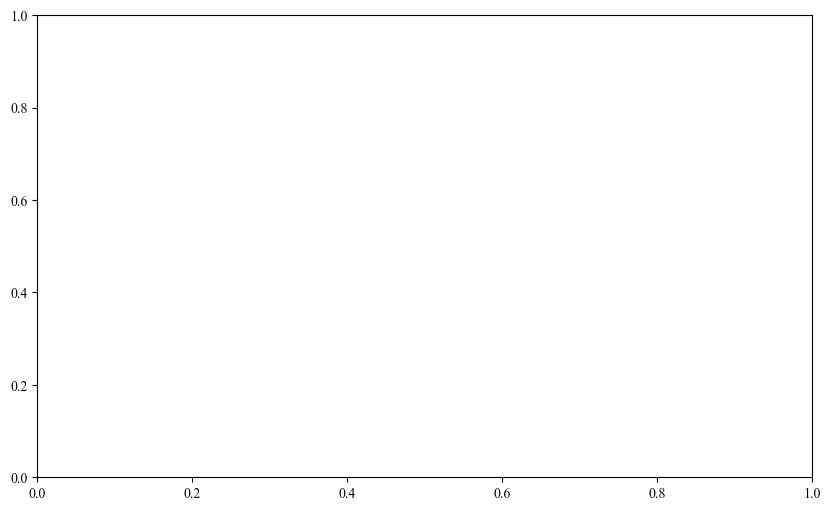

In [46]:
# 绘制声子谱
plt.figure(figsize=(10, 6))

for band in range(nbands):
    plt.plot(distances, frequencies[:, band], color='blue', linwidth=0.5)

# 添加高对称点的垂直线和标签
for d, label in zip(high_symmetry_distances, high_symmetry_labels):
    plt.axvline(x=d, color='k', linestyle='--', linewidth=0.5)
    plt.text(d, plt.ylim()[0]-(plt.ylim()[1]-plt.ylim()[0])*0.5, label,
             horizontalalignment='center', verticalalignment='top', fontsize=8)


# 设置x轴刻度
plt.xticks(high_symmetry_distances, high_symmetry_labels, fontsize=12)

# 设置标签和标题
plt.xlabel('Wave Vector Path', fontsize=14)
plt.ylabel('Frequency (THz)', fontsize=14)
plt.title('Phonon Band Structure', fontsize=16)

# 设置y轴的范围，考虑负频率
y_min = min(np.min(frequencies), 0)
y_max = max(np.max(frequencies), 0)
plt.ylim(y_min-(y_max-y_min)*0.5, y_max+(y_max-y_min)*0.05)

# 添加网格
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
